Matplotlib is building the font cache; this may take a moment.
C:\Users\Clement\AppData\Local\Temp\ipykernel_3008\1314119216.py:34: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df1 = pd.read_sql(query_1, conn)


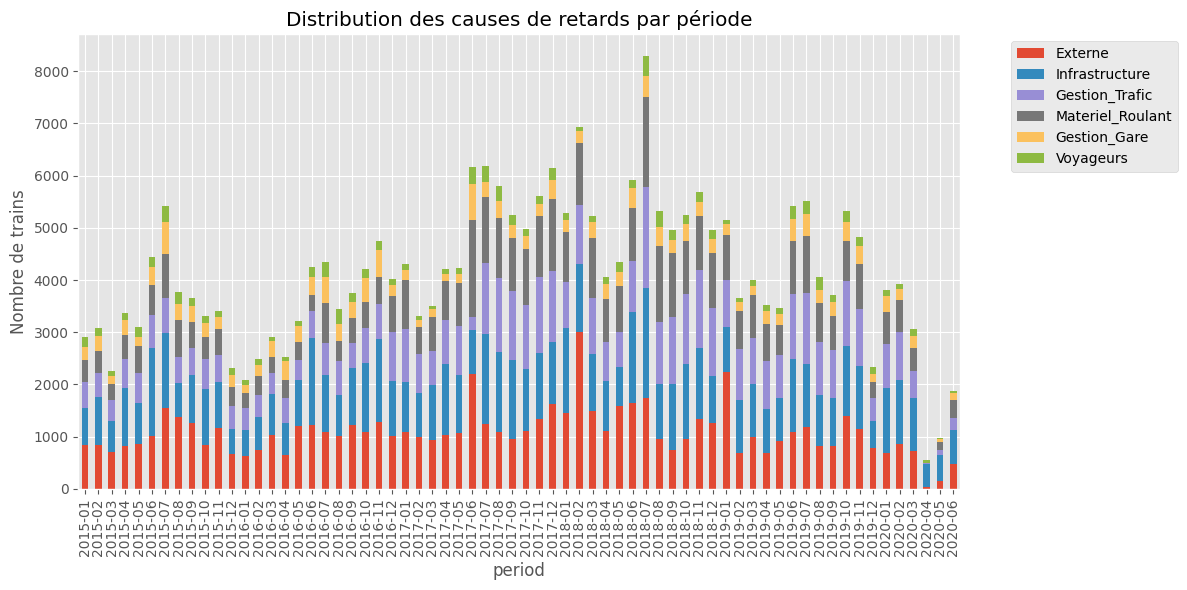

C:\Users\Clement\AppData\Local\Temp\ipykernel_3008\1314119216.py:55: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df2 = pd.read_sql(query_2, conn)


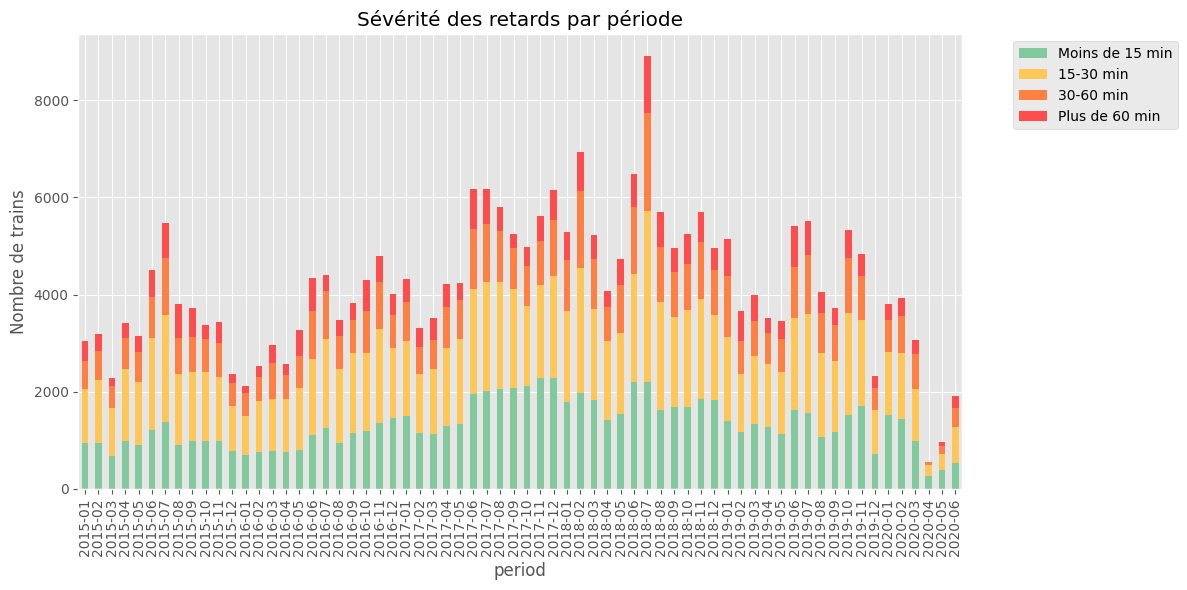

C:\Users\Clement\AppData\Local\Temp\ipykernel_3008\1314119216.py:78: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df3 = pd.read_sql(query_3, conn)


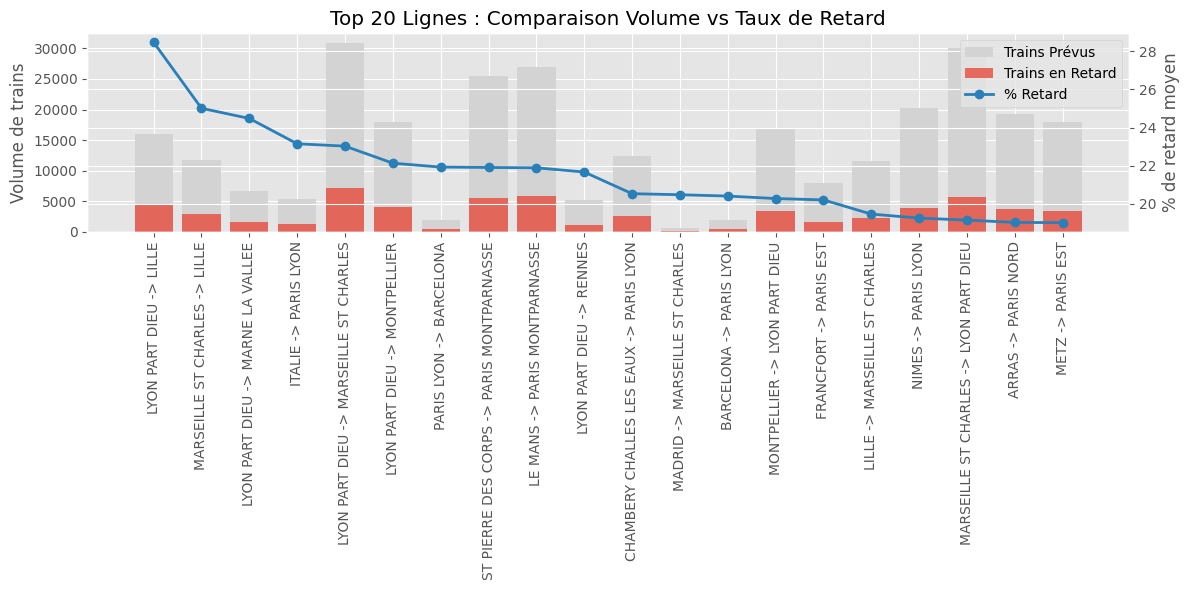

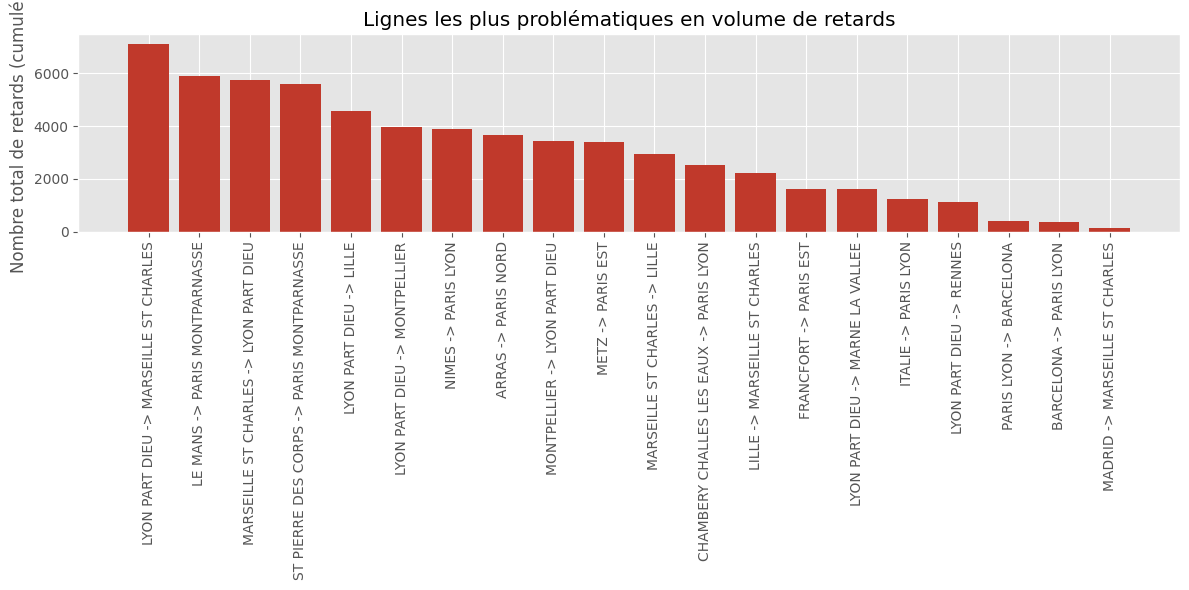

In [ ]:
import boto3
import pandas as pd
import matplotlib.pyplot as plt
from pyathena import connect

# --- CONFIGURATION ---
region = 'us-east-1'
database_name = 'database-sncfmc'
table_name = 'data_source_sncfmc'
s3_staging_dir = 's3://query-result-sncfmc/athena-results/'

# Connexion à Athena
conn = connect(s3_staging_dir=s3_staging_dir, region_name=region)

# Configuration globale des graphiques
plt.style.use('ggplot') # Utilise un style propre par défaut
plt.rcParams['figure.figsize'] = [12, 6]

# VISUEL 1 : Distribution des raisons de retards
query_1 = f"""
SELECT 
    period,
    SUM(nb_late_arr * (delay_cause_external / 100)) AS Externe,
    SUM(nb_late_arr * (delay_cause_infra / 100)) AS Infrastructure,
    SUM(nb_late_arr * (delay_cause_traffic / 100)) AS Gestion_Trafic,
    SUM(nb_late_arr * (delay_cause_rolling_stock / 100)) AS Materiel_Roulant,
    SUM(nb_late_arr * (delay_cause_station / 100)) AS Gestion_Gare,
    SUM(nb_late_arr * (delay_cause_travelers / 100)) AS Voyageurs
FROM "{database_name}"."{table_name}"
GROUP BY period ORDER BY period
"""
df1 = pd.read_sql(query_1, conn)
df1.plot(kind='bar', x='period', stacked=True)
plt.title("Distribution des causes de retards par période")
plt.ylabel("Nombre de trains")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# VISUEL 2 : Distribution des durées de retards
query_2 = f"""
SELECT 
    period,
    SUM(nb_late_before_15) AS "Moins de 15 min",
    SUM(nb_late_over_15 - nb_late_over_30) AS "15-30 min",
    SUM(nb_late_over_30 - nb_late_over_60) AS "30-60 min",
    SUM(nb_late_over_60) AS "Plus de 60 min"
FROM "{database_name}"."{table_name}"
GROUP BY period ORDER BY period
"""
df2 = pd.read_sql(query_2, conn)
df2.plot(kind='bar', x='period', stacked=True, color=['#82ca9d', '#ffc658', '#ff8042', '#ff4d4d'])
plt.title("Sévérité des retards par période")
plt.ylabel("Nombre de trains")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# VISUEL 3 : Comparaison Prévus vs Retards (Top 20 Lignes)
query_3 = f"""
SELECT 
    departure_station || ' -> ' || arrival_station AS trajet,
    SUM(nb_expected) AS total_prevus,
    SUM(nb_late_arr) AS total_retards,
    (SUM(nb_late_arr) * 100.0 / SUM(nb_expected)) AS pct_retard
FROM "{database_name}"."{table_name}"
GROUP BY departure_station, arrival_station
HAVING SUM(nb_expected) > 500
ORDER BY pct_retard DESC
LIMIT 20
"""
df3 = pd.read_sql(query_3, conn)

fig, ax1 = plt.subplots()

# Barres de volume (Prévus)
ax1.bar(df3['trajet'], df3['total_prevus'], color='lightgrey', label='Trains Prévus')
# Barres de volume (Retards) superposées
ax1.bar(df3['trajet'], df3['total_retards'], color='#e74c3c', label='Trains en Retard', alpha=0.8)

ax1.set_ylabel('Volume de trains')
ax1.tick_params(axis='x', rotation=90)

# Ajout de la courbe de pourcentage
ax2 = ax1.twinx()
ax2.plot(df3['trajet'], df3['pct_retard'], color='#2980b9', marker='o', linewidth=2, label='% Retard')
ax2.set_ylabel('% de retard moyen')

plt.title("Top 20 Lignes : Comparaison Volume vs Taux de Retard")
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.tight_layout()
plt.show()

# VISUEL 4 : Les lignes ayant le plus de volume de retard cumulé
df4 = df3.sort_values('total_retards', ascending=False).head(20)

plt.figure()
plt.bar(df4['trajet'], df4['total_retards'], color='#c0392b')
plt.xticks(rotation=90)
plt.ylabel("Nombre total de retards (cumulé)")
plt.title("Lignes les plus problématiques en volume de retards")
plt.tight_layout()
plt.show()